# Pipelines

## Setup

### Environment

* Base Python3.0
* ml.t3.medium
* 2 vCPU + 4 GiB

### Dependencies

In [41]:
!pip uninstall sagemaker -y
!pip uninstall sckikit-learn -y

Found existing installation: sagemaker 2.157.0
Uninstalling sagemaker-2.157.0:
  Successfully uninstalled sagemaker-2.157.0


In [42]:
!pip install -q sagemaker
!pip install -q -U scikit-learn


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Imports

In [43]:
import json
import logging
import pathlib

import sagemaker
import sklearn.model_selection
from sagemaker import Session, get_execution_role, image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.transformer import Transformer
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow import pipeline, pipeline_context, parameters, steps
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep, JsonGet
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.steps import (
    CreateModelStep,
    ProcessingStep,
    TrainingStep,
    TransformStep,
)
from sagemaker.workflow.step_collections import RegisterModel
from scripts import shared_constants

### Define SageMaker session and role

In [44]:
sagemaker_session = Session()
role = get_execution_role()

In [45]:
print(sagemaker.__version__) # 2.157.0

2.157.0


### Define Constants

In [46]:
SKLEARN_FRAMEWORK_VERSION = "1.0-1"
BASE_JOB_NAME = "birds-200-pipeline"
PIPELINE_NAME = "Birds200Pipeline"
IS_LOCAL_PIPELINE = False
REGION = "us-east-1"
MAP_THRESHOLD = -1.0 # because this model is really bad
MODEL_PACKAGE_GROUP_NAME = "birds-200-package-group"

## Build Model Pipeline

### Parameters

#### Define processing step parameters

In [47]:
PREPROCESSING_INSTANCE_TYPE = "PreprocessingInstanceType"
PREPROCESSING_INSTANCE_COUNT = "PreprocessingInstanceCount"
preprocessing_instance_type = parameters.ParameterString(name=PREPROCESSING_INSTANCE_TYPE, default_value="ml.m5.large")
preprocessing_instance_count = parameters.ParameterInteger(name=PREPROCESSING_INSTANCE_COUNT, default_value=1)

#### Define training step parameters

In [48]:
TRAINING_INSTANCE_TYPE = "TrainingInstanceType"
training_instance_type = parameters.ParameterString(name=TRAINING_INSTANCE_TYPE, default_value="ml.g4dn.4xlarge")

#### Define model step parameters

In [49]:
MODEL_INSTANCE_TYPE = "ModelInstanceType"
model_instance_type = parameters.ParameterString(name=MODEL_INSTANCE_TYPE, default_value="ml.m5.xlarge")

#### Define transform step parameters

In [50]:
TRANSFORM_INSTANCE_TYPE = "TransformInstanceType"
TRANSFORM_INSTANCE_COUNT = "TransformInstanceCount"
transform_instance_type = parameters.ParameterString(name=TRANSFORM_INSTANCE_TYPE, default_value="ml.m5.large")
transform_instance_count = parameters.ParameterInteger(name=TRANSFORM_INSTANCE_COUNT, default_value=1)

#### Define evaluation step parameters

In [51]:
EVALUATION_INSTANCE_TYPE = "EvaluationInstanceType"
EVALUATION_INSTANCE_COUNT = "EvaluationInstanceCount"
evaluation_instance_type = parameters.ParameterString(name=EVALUATION_INSTANCE_TYPE, default_value="ml.m5.large")
evaluation_instance_count = parameters.ParameterInteger(name=EVALUATION_INSTANCE_COUNT, default_value=1)

#### Define register model step parameters

In [52]:
INFERENCE_INSTANCE_TYPE = "InferenceInstanceType"
inference_instance_type = parameters.ParameterString(name=INFERENCE_INSTANCE_TYPE, default_value="ml.m5.large")

### Helpers

In [53]:
def generate_step_name(step):
    return f"{PIPELINE_NAME}-{step}"

### Pipeline Session

Use LocalPipelineSession for initial development. Then when confident with changes, switch to PipelineSession.

In [54]:
if IS_LOCAL_PIPELINE:
    pipeline_session = sagemaker.workflow.pipeline_context.LocalPipelineSession()
else:
    pipeline_session = sagemaker.workflow.pipeline_context.PipelineSession()

### Workflow Steps

#### Processing Step

##### Define SKLearn processor

In [55]:
preprocessing_sklearn_processor = SKLearnProcessor(
    framework_version=SKLEARN_FRAMEWORK_VERSION,
    instance_type=preprocessing_instance_type,
    instance_count=preprocessing_instance_count,
    base_job_name=BASE_JOB_NAME,
    role=role,
    sagemaker_session=pipeline_session,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


##### Define Preprocessing Step

In [56]:
preprocessing_step = ProcessingStep(
    name=generate_step_name("Preprocessing"),
    processor=preprocessing_sklearn_processor,
    inputs=[
        ProcessingInput(
            source="./scripts",
            destination=str(shared_constants.INPUT_DIR),
            input_name="scripts",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name=str(output_name), source=str(source))
        for (output_name, source) in [
            (shared_constants.TRAIN_CHANNEL, shared_constants.TRAIN_DIR),
            (shared_constants.VALIDATION_CHANNEL, shared_constants.VALIDATION_DIR),
            (shared_constants.TEST_CHANNEL, shared_constants.TEST_DIR),
            (shared_constants.LABELS_CHANNEL, shared_constants.LABELS_DIR),
        ]
    ],
    code="./scripts/install_packages.py",
)

#### Training Step

I utilize the built-in Docker image and model for object detection. One can also use a custom model within a prebuilt image or deploy a custom image. Here are some helpful resources:
* Learn more about training with Amazon SageMaker: [link](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
* Explore an example of using PyTorch for MNIST classification in SageMaker: [link](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-python-sdk/pytorch_mnist/pytorch_mnist.ipynb)
* Understand Docker containers in SageMaker: [link](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)

##### Get training image

In [57]:
training_image = sagemaker.image_uris.retrieve(region=REGION, framework="object-detection", version="latest")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


##### Define estimator

In [58]:
estimator = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type=training_instance_type,
    volume_size=50,
    max_run=int(3600*1.5),
    input_mode="File",
    output_path=shared_constants.S3_OUTPUT_OBJECT_KEY,
    sagemaker_session=pipeline_session,
    base_job_name=BASE_JOB_NAME,
)

For information on object-detection hyperparameters, refer to the documentation at: https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-api-config.html.

##### Set hyperparameters

In [59]:
estimator.set_hyperparameters(
    num_classes=len(shared_constants.CLASS_IDS),
    num_training_samples=shared_constants.NUM_TRAINING_SAMPLES,
)

##### Define estimator inputs

In [60]:
estimator_inputs = {
    "train": TrainingInput(
        s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[shared_constants.TRAIN_CHANNEL].S3Output.S3Uri,
        content_type="application/x-recordio",
    ),
    "validation": TrainingInput(
        s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[shared_constants.VALIDATION_CHANNEL].S3Output.S3Uri,
        content_type="application/x-recordio",
    ),
}

##### Define training step

In [61]:
training_step = TrainingStep(
    name=generate_step_name("Training"),
    estimator=estimator,
    inputs=estimator_inputs,
)

#### Model Step

##### Define model from trained estimator data

In [62]:
model = sagemaker.model.Model(
    image_uri=estimator.training_image_uri(),
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

##### Create model step

In [63]:
model_step = ModelStep(
   name=generate_step_name("CreateModel"),
   step_args=model.create(instance_type=model_instance_type),
)

/usr/local/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:270: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


#### Batch Transform step

##### Define transformer

In [64]:
transformer = Transformer(
    model_name=model_step.properties.ModelName,
    instance_count=transform_instance_count,
    instance_type=transform_instance_type,
    sagemaker_session=pipeline_session,
)

##### Define transform step

In [65]:
transform_step = TransformStep(
    name=generate_step_name("Transform"),
    step_args=transformer.transform(
        data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            shared_constants.TEST_CHANNEL
        ].S3Output.S3Uri
    ),
)


#### Evaluation Step

##### Create the SKLearn processor

In [66]:
evaluation_sklearn_processor = sagemaker.sklearn.processing.SKLearnProcessor(
    framework_version=SKLEARN_FRAMEWORK_VERSION,
    instance_type=evaluation_instance_type,
    instance_count=evaluation_instance_count,
    base_job_name=BASE_JOB_NAME,
    role=role,
    sagemaker_session=pipeline_session,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


##### Create the evaluation step (i.e. the processing step for evaluation)

In [67]:
evaluation_report_property_file = PropertyFile(
    name="EvaluationReport", output_name=shared_constants.EVALUATION_CHANNEL, path="evaluation.json"
)

In [68]:
evaluation_step = ProcessingStep(
    name=generate_step_name("Evaluation"),
    processor=evaluation_sklearn_processor,
    inputs=[
        ProcessingInput( # A trick that allows imports modules in scripts
            source="./scripts",
            destination=str(shared_constants.INPUT_DIR),
            input_name="scripts",
        ),
        ProcessingInput(
            source=transform_step.properties.TransformOutput.S3OutputPath,
            destination=str(shared_constants.TRANSFORM_DIR),
        ),
        ProcessingInput(
            source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[shared_constants.LABELS_CHANNEL].S3Output.S3Uri,
            destination=str(shared_constants.LABELS_DIR),
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name=shared_constants.EVALUATION_CHANNEL,
            source=str(shared_constants.EVALUATION_DIR),
        )
    ],
    code='scripts/run_evaluate.py',
    property_files=[evaluation_report_property_file],
)

#### Register Model Step

In [72]:
register_model_step_args = model.register(
    content_types=["image/jpeg", "image/png"],
    response_types=["application/json"],
    inference_instances=[inference_instance_type],
    transform_instances=[transform_instance_type],
    model_package_group_name = MODEL_PACKAGE_GROUP_NAME,
)

In [73]:
register_step = ModelStep(
    name=generate_step_name("RegisterModel"),
    step_args=register_model_step_args,
)

#### Fail Step

In [74]:
fail_step = FailStep(
    name=generate_step_name("Fail"),
    error_message=f"Execution failured due to mAP score < {MAP_THRESHOLD}",
)

#### Condition Step

In [75]:
cond_map_score = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step=evaluation_step,
        property_file=evaluation_report_property_file,
        json_path="map"
    ),
    right=MAP_THRESHOLD,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [76]:
condition_step = ConditionStep(
    name=generate_step_name("CheckMapScore"),
    conditions=[cond_map_score],
    if_steps=[register_step],
    else_steps=[fail_step],
)

### Create the Pipeline

In [77]:
pipeline = sagemaker.workflow.pipeline.Pipeline(
    name=PIPELINE_NAME,
    parameters=[
        preprocessing_instance_type,
        preprocessing_instance_count,
        training_instance_type,
        model_instance_type,
        transform_instance_type,
        transform_instance_count,
        evaluation_instance_type,
        evaluation_instance_count,
        inference_instance_type,
    ],
    steps=[
        preprocessing_step,
        training_step,
        model_step,
        transform_step,
        evaluation_step,
        condition_step,
    ],
    sagemaker_session=pipeline_session,
)

#### Inspect the Pipeline Definition

The graphical user interface in the Pipelines tab is more user-friendly and easier to understand.

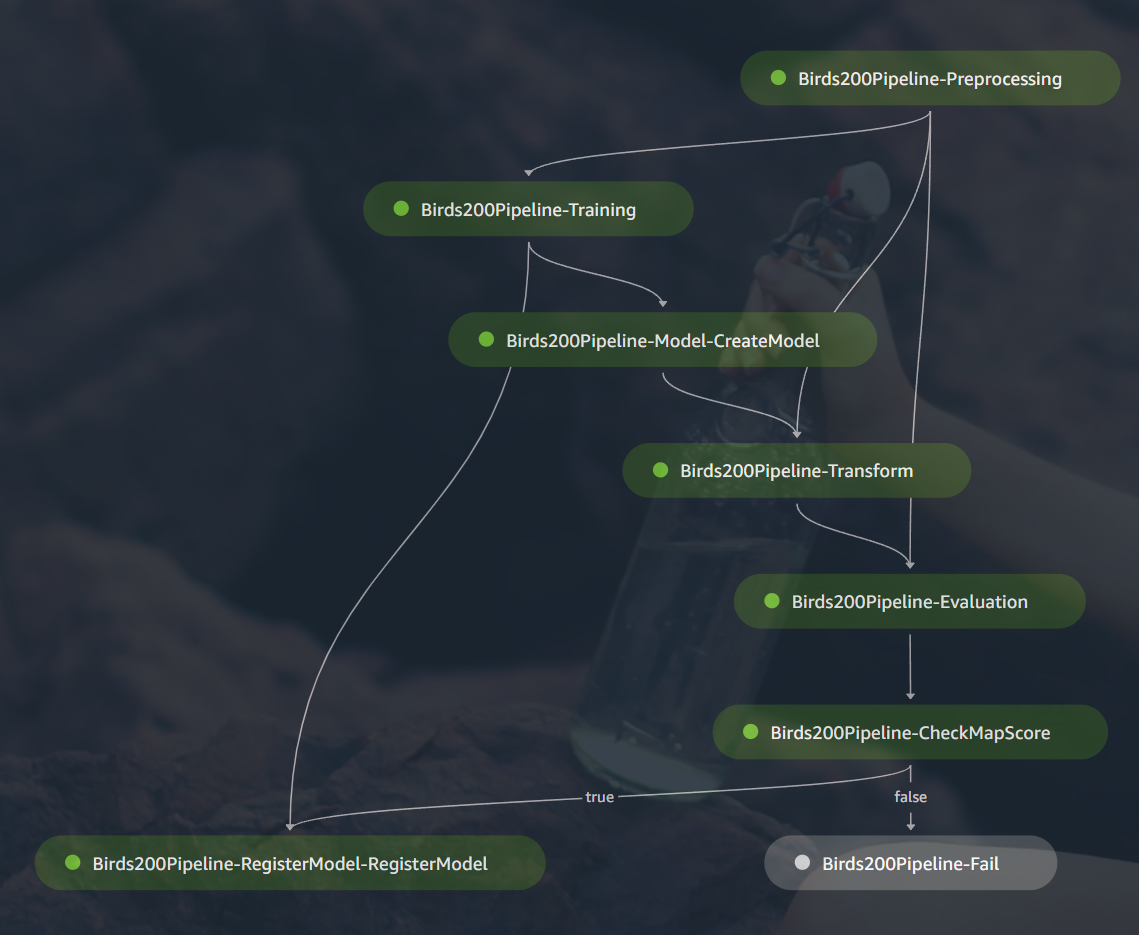

In [78]:
#json.loads(pipeline.definition())

### Build the Pipeline

In [79]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:180797159824:pipeline/birds200pipeline',
 'ResponseMetadata': {'RequestId': '135ed4ee-a41f-4903-98de-d3a74612ea07',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '135ed4ee-a41f-4903-98de-d3a74612ea07',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '84',
   'date': 'Fri, 19 May 2023 17:03:24 GMT'},
  'RetryAttempts': 0}}

In [80]:
execution = pipeline.start()

In [82]:
execution.wait()

In [83]:
execution.list_steps()

[{'StepName': 'Birds200Pipeline-RegisterModel-RegisterModel',
  'StartTime': datetime.datetime(2023, 5, 19, 17, 33, 38, 473000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 5, 19, 17, 33, 39, 371000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:180797159824:model-package/birds-200-package-group/1'}},
  'AttemptCount': 0},
 {'StepName': 'Birds200Pipeline-CheckMapScore',
  'StartTime': datetime.datetime(2023, 5, 19, 17, 33, 37, 487000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 5, 19, 17, 33, 37, 729000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'Condition': {'Outcome': 'True'}},
  'AttemptCount': 0},
 {'StepName': 'Birds200Pipeline-Evaluation',
  'StartTime': datetime.datetime(2023, 5, 19, 17, 28, 58, 125000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 5, 19, 17, 33, 36, 940000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'